<a href="https://colab.research.google.com/github/edmanft/Drug_Synergy/blob/main/Word_embeddings_colaboratory_19_2_2021.ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>





# Loading packages

In [1]:
!pip install fastai --upgrade
!pip install dtreeviz
!pip install fastbook

In [2]:
import fastbook
fastbook.setup_book()

Mounted at /content/gdrive


In [3]:
from fastbook import *

from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from dtreeviz.trees import *
from IPython.display import Image, display_svg, SVG

pd.options.display.max_rows = 20
pd.options.display.max_columns = 8

# Loading Data

In [75]:
path = "/content/gdrive/MyDrive/archivos_tfm/saezr_nc19_DataS1_modificado.xlsx"
sheet_to_df_map = pd.read_excel(path, sheet_name=None)
df_drug_comb = sheet_to_df_map["Drug combinations Ch1"]


/usr/local/lib/python3.7/dist-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


In [76]:
df_drug_comb.head(10)

,Cell line name,Compound A,Compound B,Max. conc. A,...,QA,Combination ID,Challenge,Dataset
0,BT-20,AKT,ADAM17,1.0,...,1,ADAM17.AKT,ch1,train
1,CAL-120,AKT,ADAM17,1.0,...,-1,ADAM17.AKT,ch1,train
2,CAL-51,AKT,ADAM17,1.0,...,1,ADAM17.AKT,ch1,train
3,DU-4475,AKT,ADAM17,1.0,...,-1,ADAM17.AKT,ch1,train
4,HCC1143,AKT,ADAM17,1.0,...,-1,ADAM17.AKT,ch1,train
5,HCC1187,AKT,ADAM17,1.0,...,1,ADAM17.AKT,ch1,train
6,HCC1428,AKT,ADAM17,1.0,...,-1,ADAM17.AKT,ch1,train
7,HCC1806,AKT,ADAM17,1.0,...,1,ADAM17.AKT,ch1,train
8,HCC1937,AKT,ADAM17,1.0,...,1,ADAM17.AKT,ch1,train
9,HCC70,AKT,ADAM17,1.0,...,1,ADAM17.AKT,ch1,train


In [77]:
df_drug_comb.columns


Index(['Cell line name', 'Compound A', 'Compound B', 'Max. conc. A',
       'Max. conc. B', 'IC50 A', 'H A', 'Einf A', 'IC50 B', 'H B', 'Einf B',
       'Synergy score', 'QA', 'Combination ID', 'Challenge', 'Dataset'],
      dtype='object')

In [78]:
print("Splits: ",df_drug_comb['Dataset'].unique())
print("Challenge: ",df_drug_comb['Challenge'].unique())

Splits:  ['train' 'LB' 'test']
Challenge:  ['ch1']


In this dataset we have a train/test/Leaderboard split. Also, all of our data refers to challege 1, so we can just drop that column later.

In [79]:
# A little bit of data analysis
df_drug_comb.describe()

,Max. conc. A,Max. conc. B,IC50 A,H A,...,H B,Einf B,Synergy score,QA
count,3879.000000,3879.000000,3879.000000,3879.000000,...,3879.000000,3879.000000,3879.000000,3879.000000
mean,1.721684,4.960581,0.733284,2.900107,...,2.902762,48.091803,10.236308,0.758443
std,1.818286,14.657023,1.021671,3.634496,...,3.704492,35.876790,116.249064,0.742968
min,0.003000,0.003000,0.000003,0.000000,...,0.000000,0.000000,-588.220700,-3.000000
25%,1.000000,1.000000,0.069179,0.507272,...,0.432883,12.537512,-5.246305,1.000000
50%,1.000000,1.000000,0.337817,1.264897,...,1.177369,47.599717,8.429529,1.000000
75%,3.000000,3.000000,1.000000,2.989752,...,3.014471,82.398922,25.385300,1.000000
max,10.000000,75.000000,10.000000,10.000000,...,10.000000,100.000000,6737.175000,1.000000


We will choose to train only in high quality data, meaning QA=1.

In [80]:
df_drug_comb = df_drug_comb[df_drug_comb["QA"] == 1]
print("Values of QA:", df_drug_comb["QA"].unique())

Values of QA: [1]


We drop QA, Combination ID and Challenge.

In [81]:
df_drug_comb.drop(['QA', 'Challenge'], axis = 1, inplace=True)


SettingWithCopyError: ignored

In [82]:
df_drug_comb.columns


Index(['Cell line name', 'Compound A', 'Compound B', 'Max. conc. A',
       'Max. conc. B', 'IC50 A', 'H A', 'Einf A', 'IC50 B', 'H B', 'Einf B',
       'Synergy score', 'Combination ID', 'Dataset'],
      dtype='object')

In [83]:
dep_var = 'Synergy score'
procs = [Categorify, FillMissing]


In [84]:
# We shuffle the data
df_drug_comb = df_drug_comb.sample(frac=1).reset_index(drop=True)
df_drug_comb.head(10)

,Cell line name,Compound A,Compound B,Max. conc. A,...,Einf B,Synergy score,Combination ID,Dataset
0,MCF7,PARP1,HSP90,1.0,...,8.300266,27.753550,HSP90.PARP1,train
1,MDA-MB-468,IAP,BCL2L1,3.0,...,41.893039,58.668530,BCL2L1.IAP,LB
2,CAL-51,PIK3CA_4,BCL2_BCL2L1,1.0,...,93.944266,14.908840,BCL2_BCL2L1.PIK3CA_4,train
3,MDA-MB-157,AKT_1,AKT,1.0,...,52.829550,10.643720,AKT.AKT_1,train
4,HCC1187,MTOR_1,MAP2K_1,1.0,...,49.805905,-0.173590,MAP2K_1.MTOR_1,train
5,HCC1395,MAP2K_1,ADAM17,1.0,...,86.364574,5.722309,ADAM17.MAP2K_1,train
6,DMS-114,SYK,CSNK2A1_2,3.0,...,17.399447,-9.067485,CSNK2A1_2.SYK,train
7,BT-20,SLC16A4,FGFR,1.0,...,72.600014,28.173540,FGFR.SLC16A4,train
8,NCI-H358,IAP,ATR_4,3.0,...,47.200781,25.453220,ATR_4.IAP,train
9,NCI-H522,PIK3C,ADAM17,3.0,...,33.363397,30.652380,ADAM17.PIK3C,LB


We create the train/test/LB splits and then create a copy of our dataset without the Combination ID. 
We want to retain the Combination ID because we use it for our Weighted Pearson metric.

In [85]:
dataset_size = df_drug_comb.shape[0]
complete_list = np.arange(dataset_size, dtype = int)

train_idx = complete_list[df_drug_comb["Dataset"]=="train"]
test_idx = complete_list[df_drug_comb["Dataset"]=="test"]
LB_idx = complete_list[df_drug_comb["Dataset"]=="test"]

# For now we ignore the LB split

splits = (list(train_idx),list(test_idx))

df_drug_comb.drop(['Dataset'], axis = 1, inplace = True)
df_nocomb = df_drug_comb.drop(['Combination ID'], axis = 1)


In [86]:
print("With Combination ID: ", df_drug_comb.columns)
print("Without Combination ID:", df_nocomb.columns )

With Combination ID:  Index(['Cell line name', 'Compound A', 'Compound B', 'Max. conc. A',
       'Max. conc. B', 'IC50 A', 'H A', 'Einf A', 'IC50 B', 'H B', 'Einf B',
       'Synergy score', 'Combination ID'],
      dtype='object')
Without Combination ID: Index(['Cell line name', 'Compound A', 'Compound B', 'Max. conc. A',
       'Max. conc. B', 'IC50 A', 'H A', 'Einf A', 'IC50 B', 'H B', 'Einf B',
       'Synergy score'],
      dtype='object')


In [87]:
cont,cat = cont_cat_split(df_nocomb, 1, dep_var=dep_var)
to = TabularPandas(df_nocomb, procs, cat, cont, y_names=dep_var, splits=splits)

In [88]:
len(to.train),len(to.valid)

(1795, 1089)

In [89]:
xs,y = to.train.xs,to.train.y
valid_xs,valid_y = to.valid.xs,to.valid.y

### Understanding xs, ym valid_xs, valid_y

In [91]:
xs.columns

Index(['Cell line name', 'Compound A', 'Compound B', 'Max. conc. A',
       'Max. conc. B', 'IC50 A', 'H A', 'Einf A', 'IC50 B', 'H B', 'Einf B'],
      dtype='object')

In [92]:
xs.head(10)

,Cell line name,Compound A,Compound B,Max. conc. A,...,Einf A,IC50 B,H B,Einf B
0,42,31,34,1.0,...,78.262459,0.036303,2.611075,8.300266
2,11,34,13,1.0,...,70.799255,0.382507,2.883548,93.944267
3,43,2,2,1.0,...,71.199257,1.000000,0.524746,52.829548
4,20,28,39,1.0,...,10.386720,0.013501,1.144306,49.805904
5,21,25,1,1.0,...,76.194229,75.000000,0.451538,86.364571
6,16,45,18,3.0,...,0.000000,0.008980,10.000000,17.399446
7,5,43,31,1.0,...,92.804436,1.000000,10.000000,72.600014
8,65,21,9,3.0,...,89.639999,3.000000,2.524424,47.200783
11,76,22,35,10.0,...,57.524136,0.061322,1.393270,83.743294
13,5,14,2,3.0,...,76.197380,1.180738,0.923729,1.901265


It converts categorical variables into numerical ones. 

In [95]:
to.classes["Compound A"]

['#na#', 'AKT', 'AKT_1', 'ALK_IGFR', 'ATR_4', 'BCL2L1', 'BCL2_2', 'BCL2_BCL2L1', 'CSNK2A1_2', 'CarboTaxol', 'Chloroquine', 'Cisplatin', 'EGFR', 'EGFR_2', 'ERBB', 'ESR1', 'ESR1_1', 'FASN', 'FGFR', 'Gemcitabine', 'HDAC_4', 'IAP', 'IGFR_3', 'IGFR_4', 'JAK', 'MAP2K_1', 'MAP2K_3', 'MTOR', 'MTOR_1', 'MTOR_3', 'Oxaliplatin', 'PARP1', 'PIK3C', 'PIK3CA_3', 'PIK3CA_4', 'PIK3CB', 'PIK3CB_PIK3CD', 'PIK3C_2', 'PIK3C_MTOR', 'PIM1', 'PIP5K1', 'PTK2', 'Proteasome_2', 'SLC16A4', 'SN38', 'SYK', 'TKI', 'TNF', 'TNFSF10', 'TNKS_PARP6', 'TOP2', 'TOP2_2', 'Topotecan', 'Vinorelbine', 'WNT']

In [98]:
y

0       27.753550
2       14.908840
3       10.643720
4       -0.173590
5        5.722309
          ...    
3468    17.140190
3469    15.775190
3470    10.178780
3473    -7.385175
3474    35.632999
Name: Synergy score, Length: 1795, dtype: float32

# Baseline model: mean and median

In [96]:
train_df = df_def[:cutoff]
train_df.describe()

NameError: ignored

  Let's see how good it performs a model whose only information is the mean or the median of the train set.

In [99]:
mean = np.mean(y)
median = np.median(y)
print(f" Median = {median} \n Mean = {mean}")

 Median = 9.755132675170898 
 Mean = 12.747153282165527


We create our metrics

In [100]:
def r_mse(pred,y): return round(math.sqrt(((pred-y)**2).mean()), 6)
def m_rmse(m, xs, y): return r_mse(m.predict(xs), y)

In [101]:
error_mean = r_mse(mean, valid_y)
error_median = r_mse(median, valid_y)
print(f" Error Median = {error_median} \n Error Mean = {error_mean}")

 Error Median = 28.020172 
 Error Mean = 27.897857


However, we now know that the correct metric is going to be a weighted Pearson correlation coefficient, which takes into account the number of cell lines used per drug pair experiment. It will give 0 for uncorrelated data.

What we want to measure is if the experimental and predicted synergy scores are correlated for every drug pair.




# Decision Trees


In [ ]:
# Now that we have preprocessed our dataset, we build the tree



Tree = DecisionTreeRegressor(max_leaf_nodes=4)
Tree.fit(xs, y);

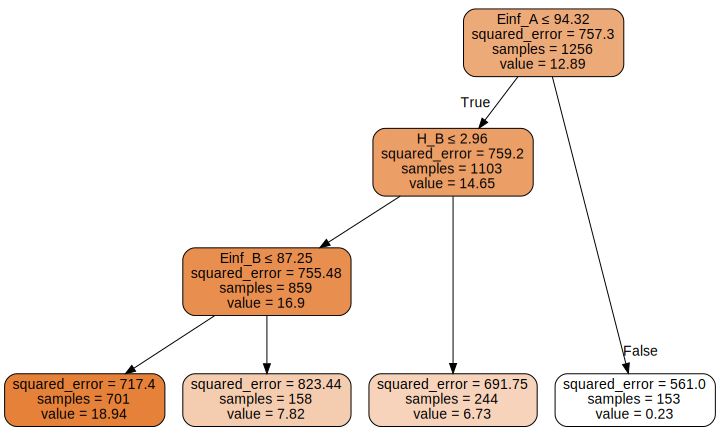

In [ ]:
draw_tree(Tree, xs, size=10, leaves_parallel=True, precision=2)


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  "X does not have valid feature names, but"


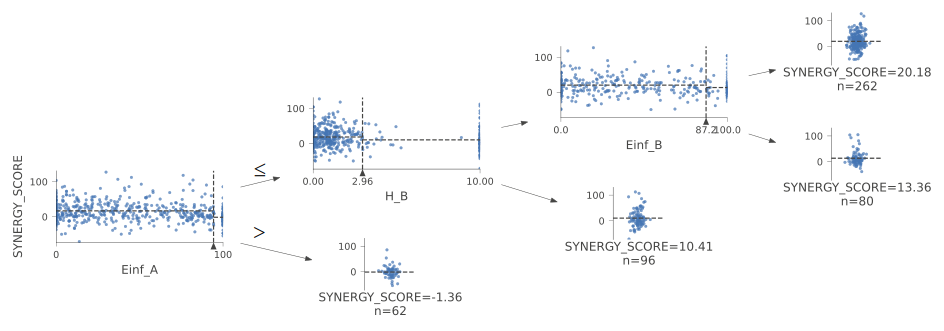

In [ ]:

samp_idx = np.random.permutation(len(y))[:500]
dtreeviz(Tree, xs.iloc[samp_idx], y.iloc[samp_idx], xs.columns, dep_var,
        fontname='DejaVu Sans', scale=1.6, label_fontsize=10,
        orientation='LR')

Let's now have the decision tree algorithm build a bigger tree. Here, we are not passing in any stopping criteria such as max_leaf_nodes:


In [ ]:
m = DecisionTreeRegressor()
m.fit(xs, y);


In [ ]:
# In the training set
m_rmse(m, xs, y)

0.0

This just means that the model fits well in the training dataset, but we have to check how well it generalizes over unseen data:

In [ ]:
m_rmse(m, valid_xs, valid_y)


37.404542

Now we will check for overfitting:

In [ ]:
m.get_n_leaves(), len(xs)

(1256, 1256)

We see that it has as many leafs as datapoints, let's see what happens if we restrict the model.

In [ ]:
m = DecisionTreeRegressor(min_samples_leaf=25)
m.fit(to.train.xs, to.train.y)
m_rmse(m, xs, y), m_rmse(m, valid_xs, valid_y)

(24.287707, 28.402236)

In [ ]:
m.get_n_leaves()


39

**The RMSE is almost the same as the baseline model. That's not good, let's try some hyperparameter tuning.**

In [ ]:
leafs = np.arange(500)+1
error_list = list()
for n_leafs in leafs:
  m = DecisionTreeRegressor(min_samples_leaf=n_leafs)
  m.fit(to.train.xs, to.train.y)
  error_list.append( m_rmse(m, valid_xs, valid_y) )

In [ ]:
error_list = np.asarray(error_list)
best_error = min(error_list)
best_leaf = leafs[error_list== min(error_list)][0]
print(f"Best number of leafs = {best_leaf} \n Error = {best_error}")

Best number of leafs = 179 
 Error = 26.609312


Not outstanding, barely better. We should try another algorithm

# Random Forest

In [ ]:
def rf(xs, y, n_estimators=100, max_samples=300,
       max_features=0.5, min_samples_leaf=5, **kwargs):
    return RandomForestRegressor(n_jobs=-1, n_estimators=n_estimators,
        max_samples=max_samples, max_features=max_features,
        min_samples_leaf=min_samples_leaf, oob_score=True).fit(xs, y)

In [ ]:
m = rf(xs, y);
m_rmse(m, xs, y), m_rmse(m, valid_xs, valid_y)


(23.733432, 26.443776)

A little better than the Tree regressor, but not that great.

## Feature importance

In [ ]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

fi = rf_feat_importance(m, xs)
fi[:10]

,cols,imp
7,H_A,0.131739
10,H_B,0.128231
8,Einf_A,0.126742
0,CELL_LINE,0.114278
11,Einf_B,0.103162
9,IC50_B,0.092686
6,IC50_A,0.088982
1,COMPOUND_A,0.078183
2,COMPOUND_B,0.072562
4,MAX_CONC_A,0.041318


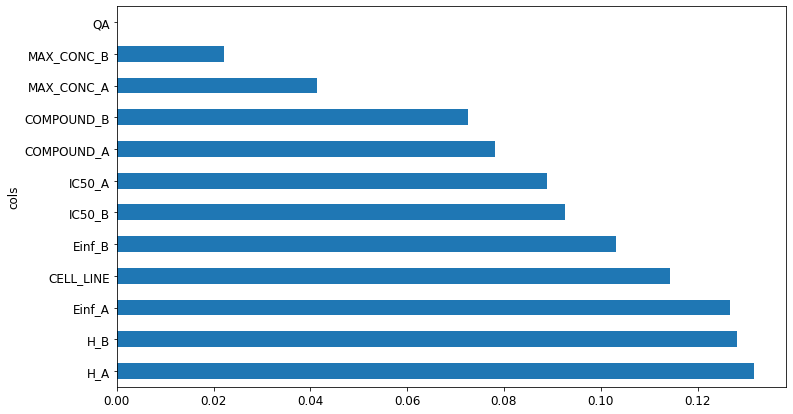

In [ ]:
def plot_fi(fi):
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

plot_fi(fi[:30]);

Here we don't have a lot of columns, so we don't have
to erase any of them.